In [1]:
# import modules
import json
from pprint import pprint
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster

from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.manifold import TSNE

# additional set up
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) # suppress scientific float notation

# constants and parameters
DATA_PATH = './data/'
IMG_PATH = './images/'

# load data 
with open(f'{DATA_PATH}data_file_20181203.json') as f:
    data = json.load(f)

Using TensorFlow backend.


In [2]:
# create data frame
df = {'name': np.zeros(len(data['quantlets'])), 
      'author_of_last_comm': np.zeros(len(data['quantlets'])),
      'is_debuggable': np.zeros(len(data['quantlets'])), 
      'grade': np.zeros(len(data['quantlets'])),
      'keywords': np.zeros(len(data['quantlets']))}

df = pd.DataFrame(data=df)

In [3]:
# extract the columns we need
for c, i in enumerate(data['quantlets']):
    df.loc[c,'name'] = i
    df.loc[c,'author_of_last_comm'] = data['quantlets'][i]['commit_last']['commit']['author']['name']
    df.loc[c,'is_debuggable'] = data['quantlets'][i]['is_debuggable']
    try:
        df.loc[c,'grade'] = data['quantlets'][i]['grade']
        df.loc[c,'keywords'] = ' '.join(str(e) for e in set(data['quantlets'][i]['keyword_list']))
    except:
        df.loc[c,'grade'] = 'did not work'
        df.loc[c,'keywords'] ='did not work'
        print('did not work')
 #   if c % 100 == 0:
 #       print(c)

df = df[df['is_debuggable']==True]

did not work
did not work
did not work
did not work
did not work
did not work
did not work


In [4]:
# text preprocessing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df.keywords.values)
train_X = tokenizer.texts_to_sequences(df.keywords.values, )
train_X = [np.unique(i) for i in train_X]
train_X = pad_sequences(train_X, maxlen=15, padding='post')
labels = [i.split('/')[1] for i in df.name]
labels = []
for i in df.name:
    temp = i.split('/')
    if len(temp)==3:
        labels.append(temp[1])
    elif len(temp)==2:
        labels.append(temp[0])
    elif len(temp)==4:
        labels.append(temp[2])
    else:
        labels.append(i)

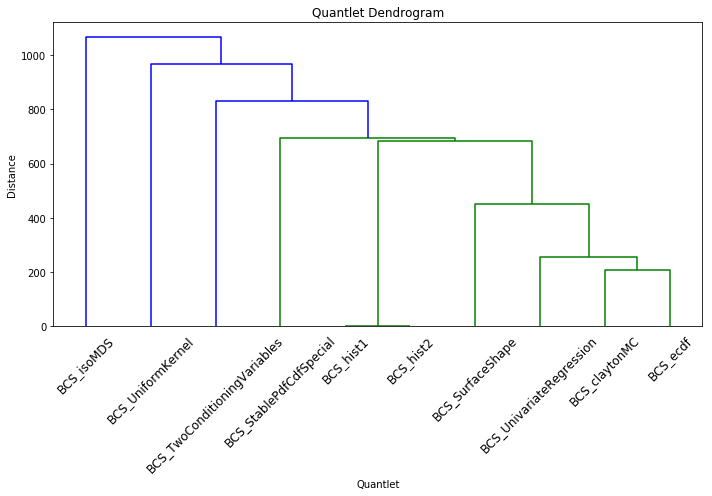

In [111]:
plt.figure(figsize=(10, 7))  
plt.title("Quantlet Dendrogram")  
plt.xlabel('Quantlet')
plt.ylabel('Distance')
Z = shc.linkage(train_X[100:110], method='single')
dend = shc.dendrogram(Z, labels=labels[100:110], leaf_rotation=45) 
plt.tight_layout()
plt.savefig(f'{IMG_PATH}dendr_small.png', transparent=True)

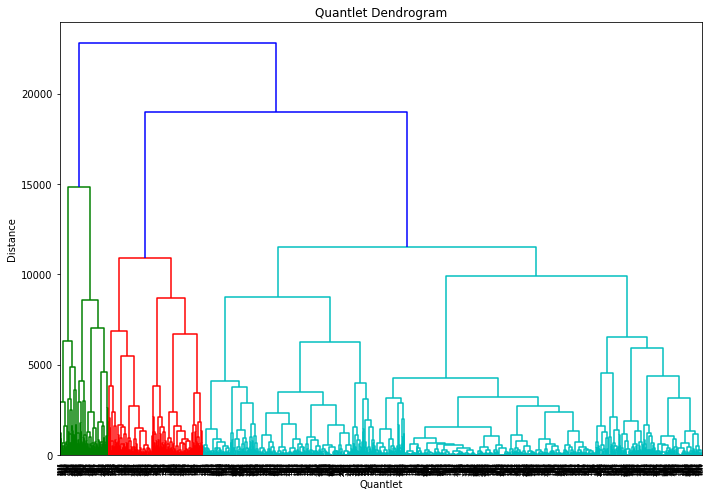

In [5]:
plt.figure(figsize=(10, 7))  
plt.title("Quantlet Dendrogram")  
plt.xlabel('Quantlet')
plt.ylabel('Distance')
Z = shc.linkage(train_X, method='ward')
dend = shc.dendrogram(Z, leaf_rotation=90)  
plt.tight_layout()
plt.savefig(f'{IMG_PATH}dendr_full.png', transparent=True)

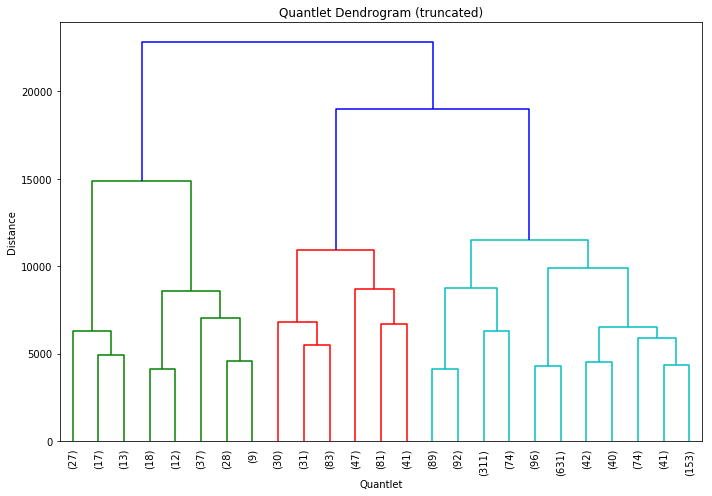

In [122]:
plt.figure(figsize=(10, 7))  
plt.title("Quantlet Dendrogram (truncated)")  
plt.xlabel('Quantlet')
plt.ylabel('Distance')
Z = shc.linkage(train_X, method='ward')
dend = shc.dendrogram(Z, truncate_mode='lastp', p=25, labels=labels, leaf_rotation=90)
plt.tight_layout()
plt.savefig(f'{IMG_PATH}dendr_trunc.png', transparent=True)

In [166]:
# find a central point of each cluster
observations = []
for i in range(1, max_d+1):
    dist = DistanceMetric.get_metric('euclidean')
    dist_sum = []
    for j in dist.pairwise(train_X[clusters==i]):
            temp = j.sum()
            dist_sum.append(temp)
    observations.append(df.keywords.values[clusters==i][np.array(dist_sum).argmin()])
observations_adj = {}
for i in observations:
    observations_adj[i] = ' '.join(str(e) for e in set(i.split()))

In [13]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [14]:
Z = shc.linkage(train_X, method='ward')
max_d = 10
clusters = fcluster(Z, max_d, criterion='maxclust')
cluster_labels = {}  
for i in range(1, max_d+1):
    df_ = pd.DataFrame(columns = ['word', 'count'])
    df_['word'], df_['count'] = np.unique(train_X[clusters==i], return_counts=True)
    df_ = df_.sort_values(by=['count'], ascending=False)
    #print(df.head(20))
    temp = []
    for word in df_.word.values[1:10]:
        temp.append(reverse_word_map[word])
    cluster_labels[i] = ' '.join(temp)            

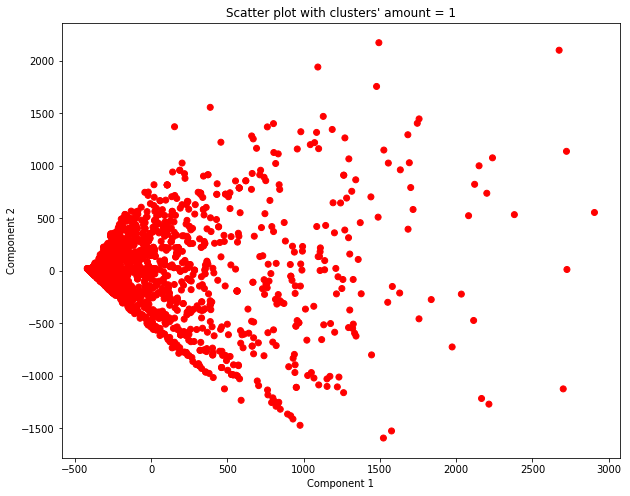

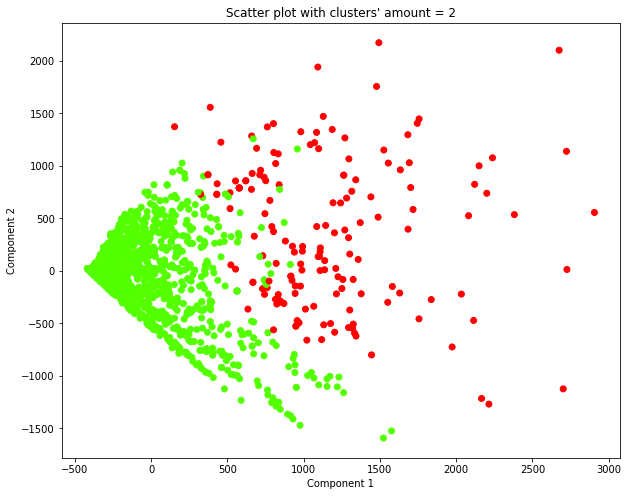

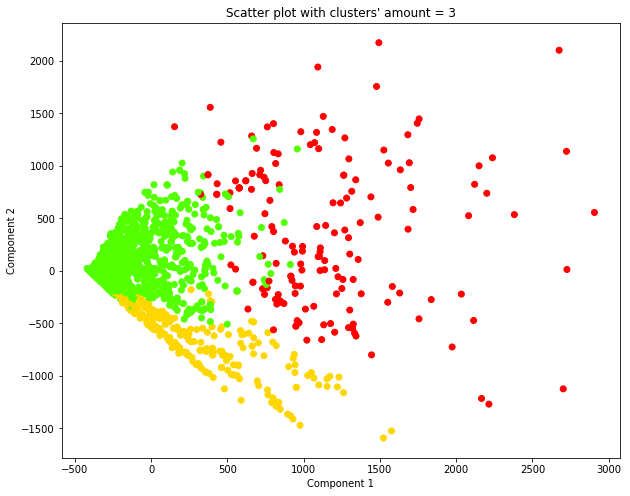

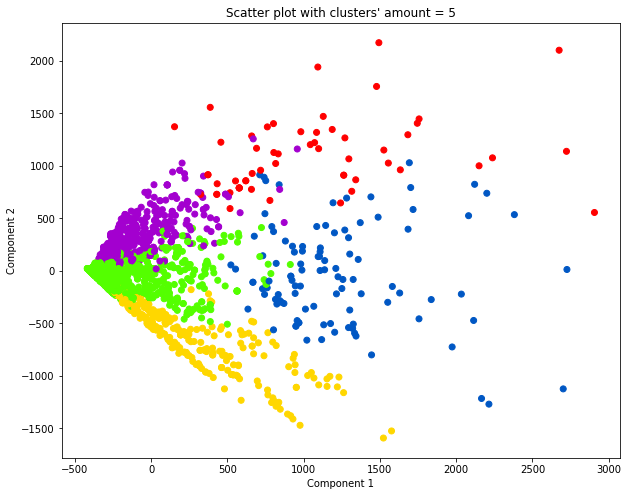

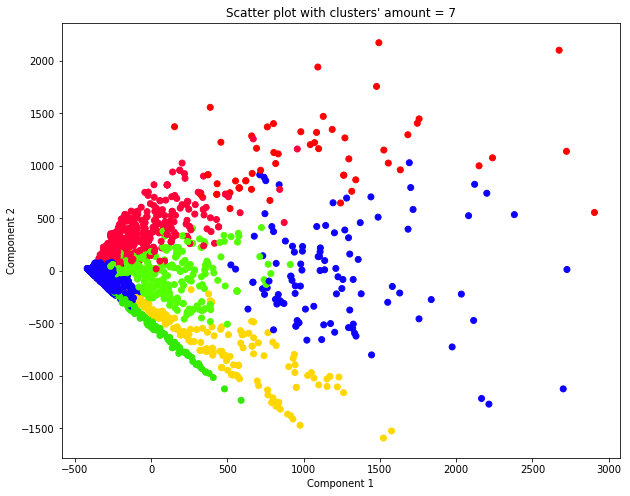

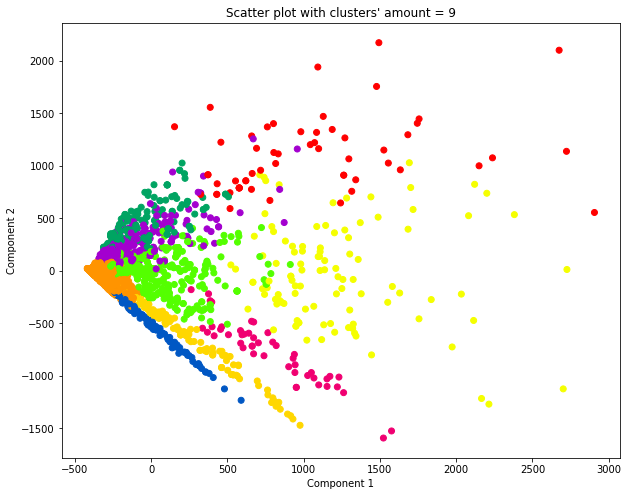

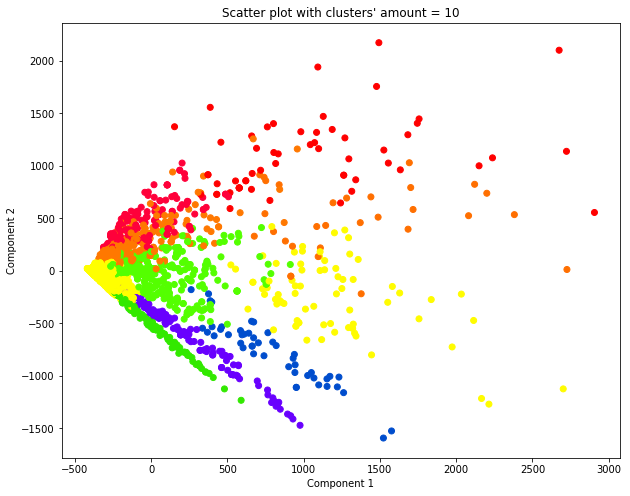

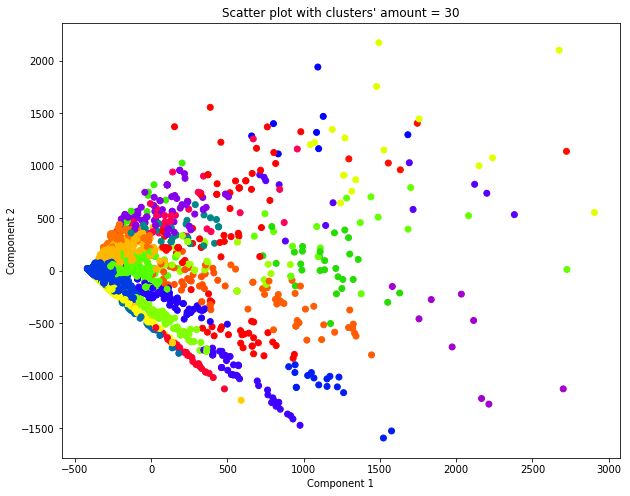

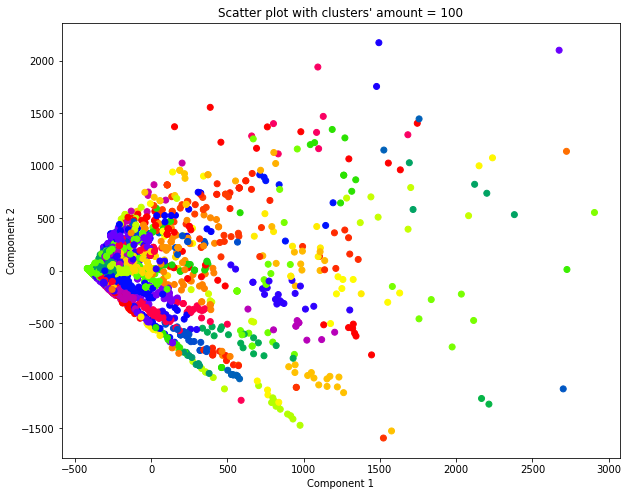

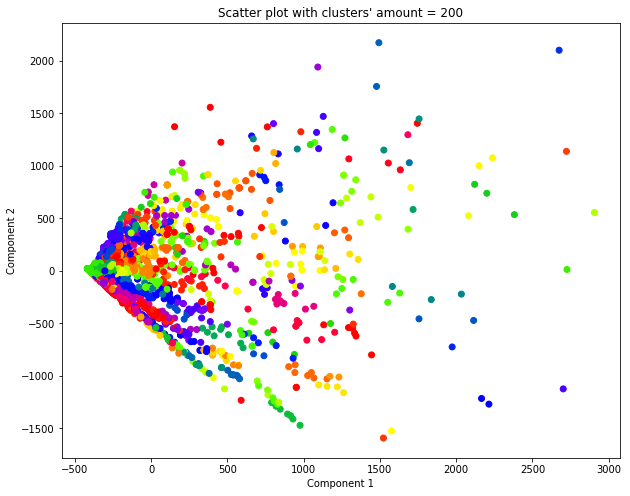

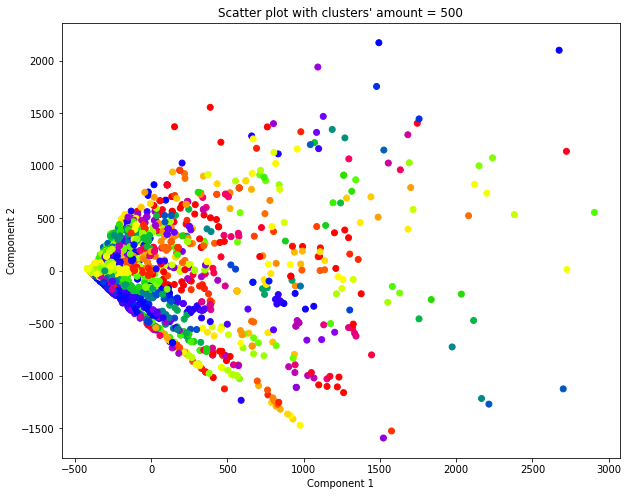

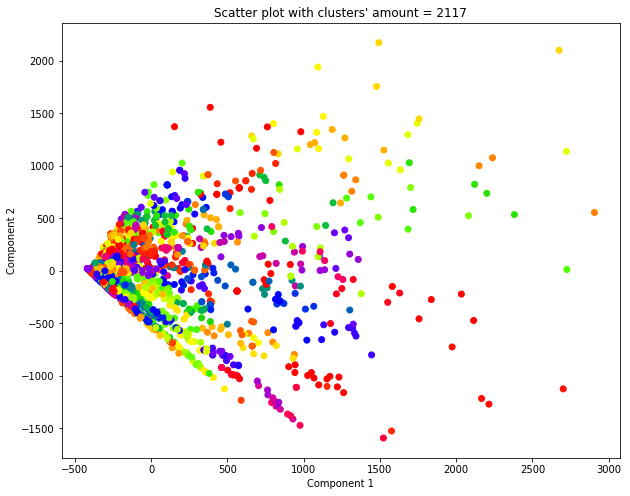

In [186]:
# prepare for plotting
pca = PCA(n_components=2)
pca.fit(train_X)
X = pca.transform(train_X)

for i in [1, 2, 3, 5, 7, 9, 10, 30, 100, 200, 500, len(df.keywords)]:
    max_d = i
    clusters = fcluster(Z, max_d, criterion='maxclust')
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'Scatter plot with clusters\' amount = {i}')
    filename=f'{IMG_PATH}for_gif/step'+str(i)+'.png'
    plt.savefig(filename, dpi=96, transparent=True)
    plt.gca()

In [15]:
tsne = TSNE(n_components=2)
tsne.fit(train_X)
X_t = tsne.fit_transform(train_X)

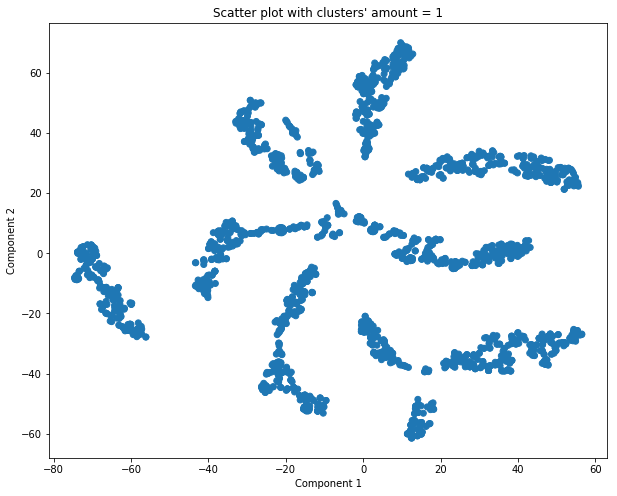

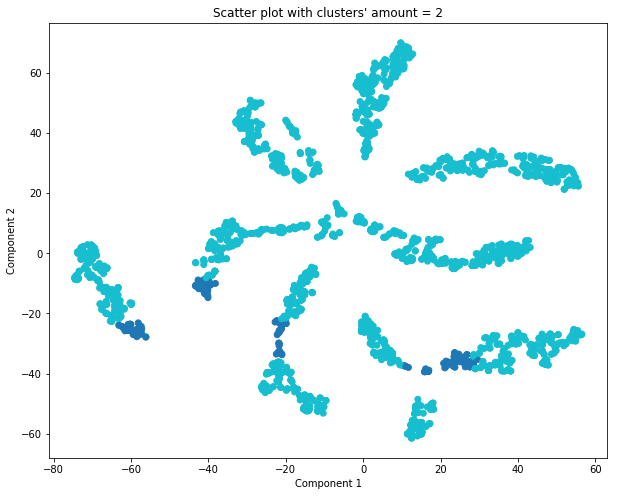

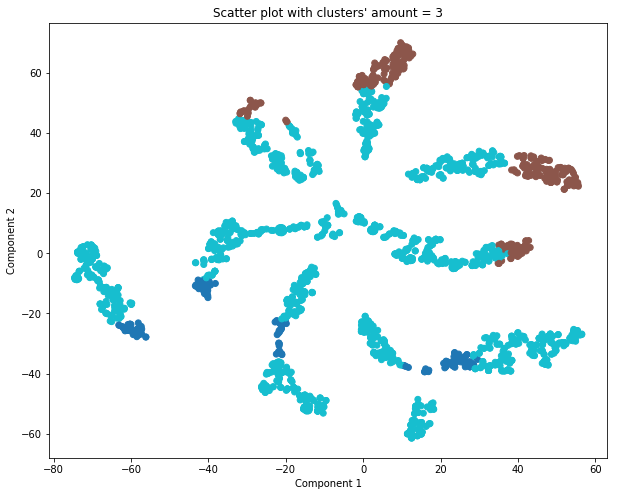

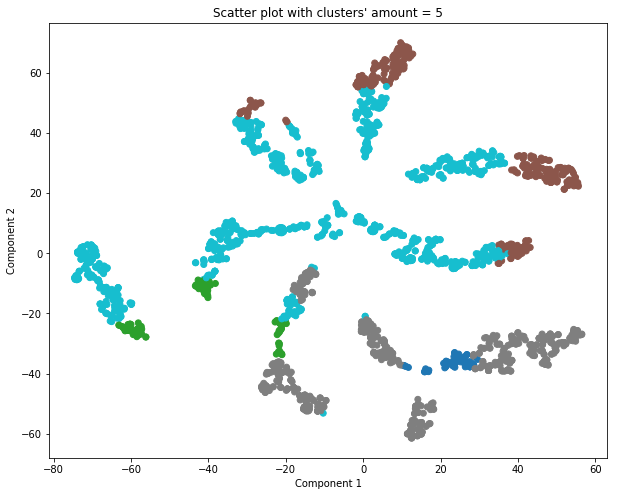

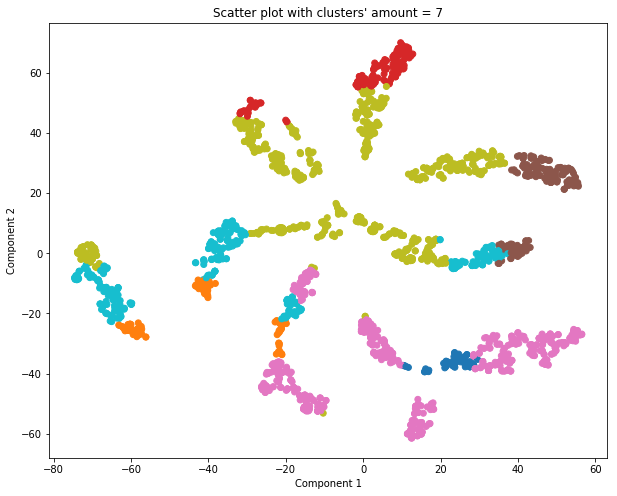

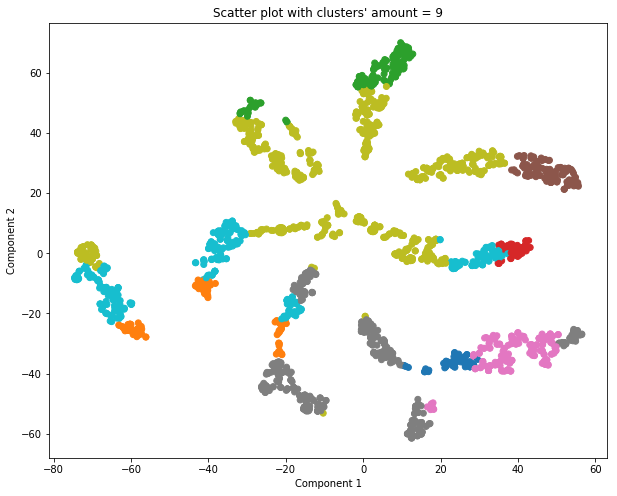

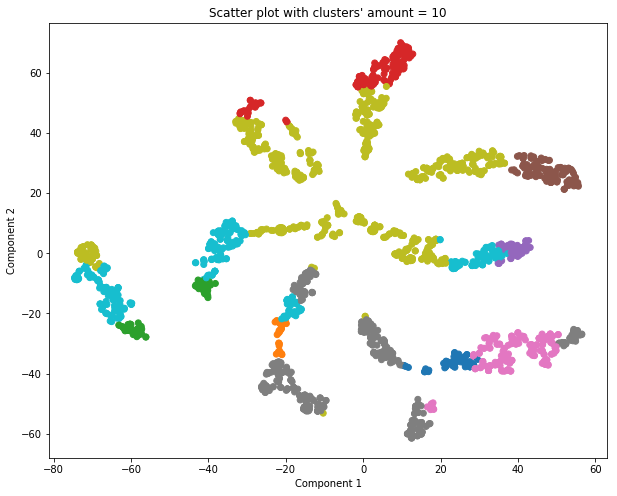

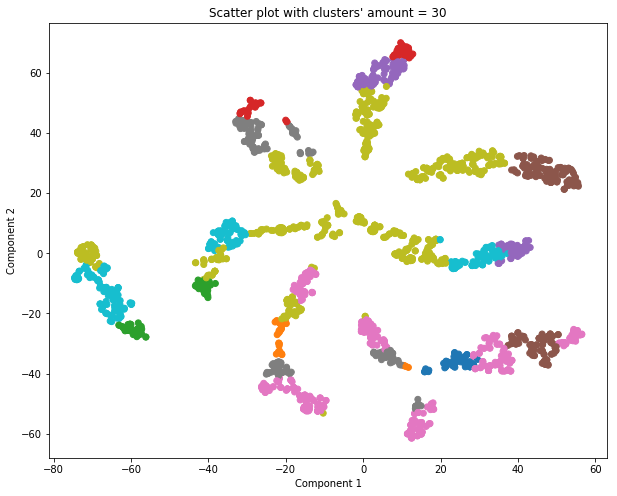

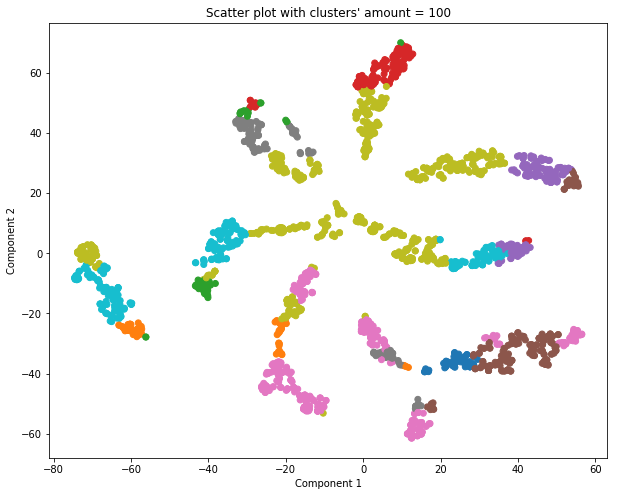

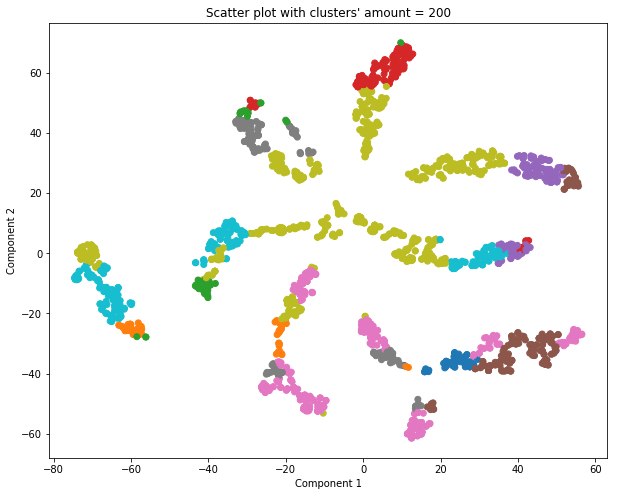

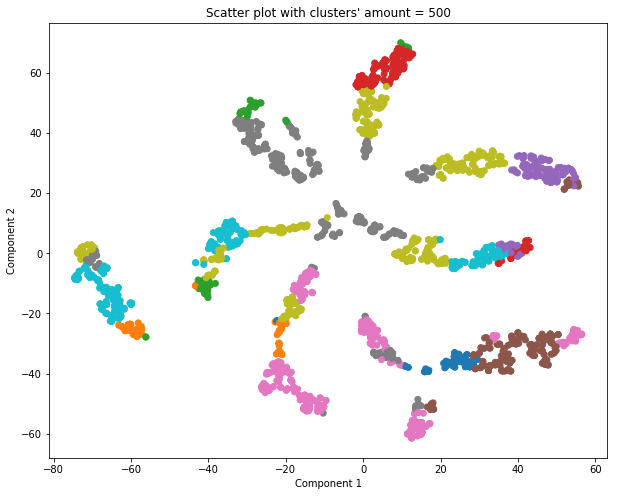

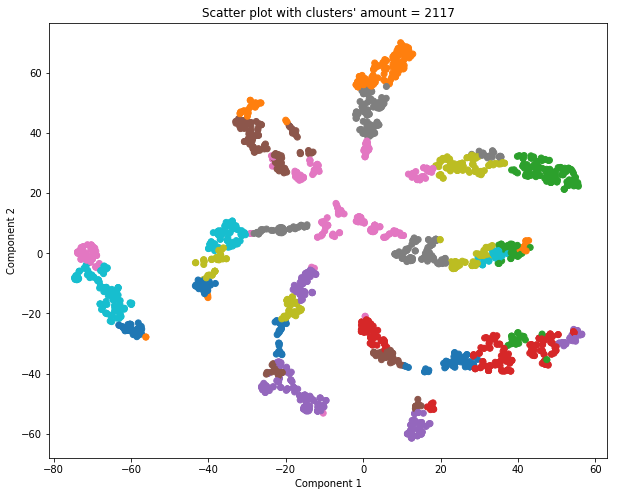

In [184]:
for i in [1, 2, 3, 5, 7, 9, 10, 30, 100, 200, 500, len(df.keywords)]:
    max_d = i
    clusters = fcluster(Z, max_d, criterion='maxclust')
    plt.figure(figsize=(10, 8))
    plt.scatter(X_t[:,0], X_t[:,1], c=clusters, cmap='tab10')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'Scatter plot with clusters\' amount = {i}')
    filename=f'{IMG_PATH}for_gif/TSNE_step'+str(i)+'.png'
    plt.savefig(filename, dpi=96, transparent=True)
    plt.gca()

In [18]:
set(clusters)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

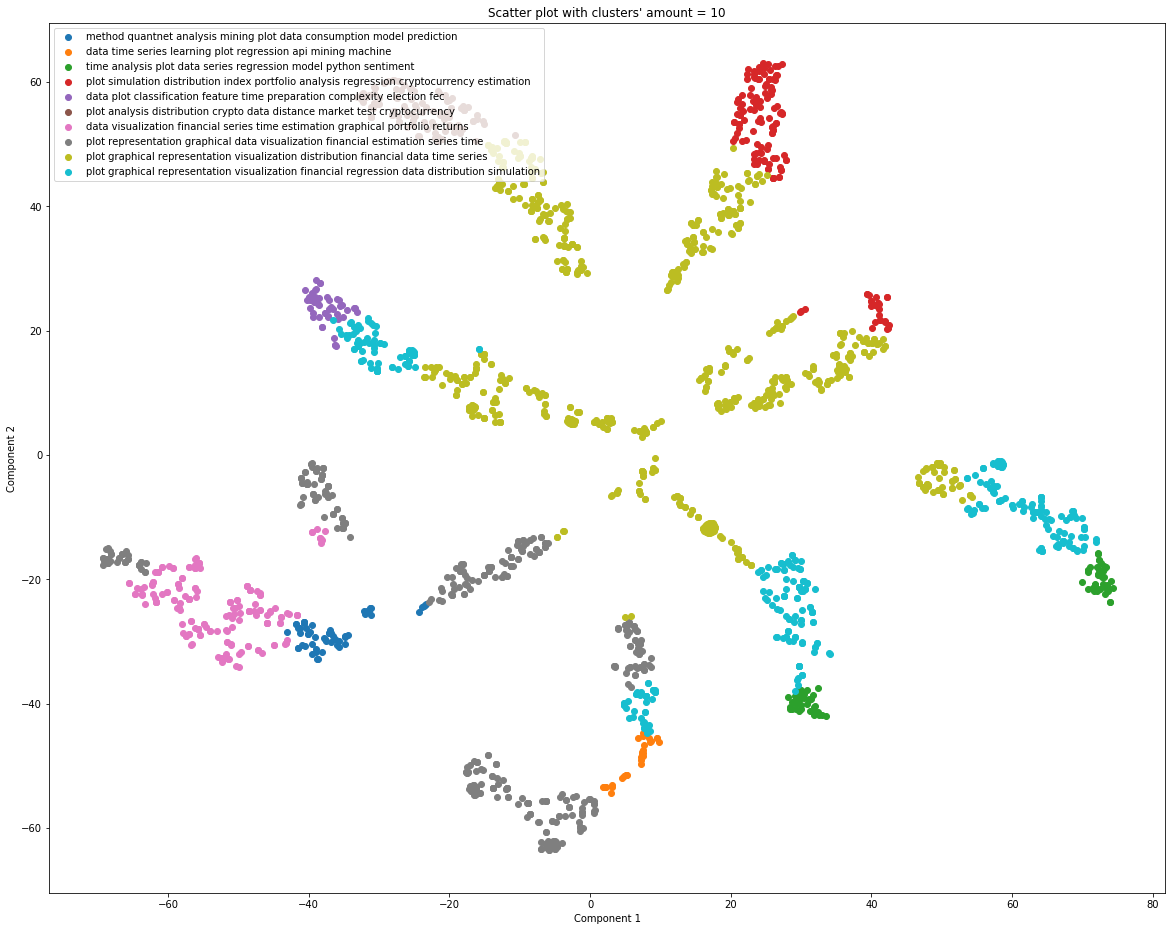

In [22]:
plt.figure(figsize=(20, 16))
for i in range(1, max_d+1):
    plt.scatter(X_t[clusters==i,0], X_t[clusters==i,1], label = cluster_labels[i])
plt.legend(loc = 'upper left', prop={'size': 10})
#plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), prop={'size': 10})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'Scatter plot with clusters\' amount = {10}')
filename=f'{IMG_PATH}TSNE_10_clusters.png'
plt.savefig(filename, dpi=96, transparent=True)
plt.gca()